# Gruppe A – BS-Seq: P8 vs. P6

## Table of Contents (answers)
- [Answer Q1: Methylraw](#answer-q1-methylraw)
- [Answer Q2: Plots discussion](#answer-q2-plots-discussion)
- [Answer Q3: Filter step](#answer-q3-filter-step)
- [Answer Q4: Downstream analysis](#answer-q4-downstream-analysis)
- [Answer Q5: Further filtering](#answer-q5-further-filtering)
- [Answer Q6: Volcano plot](#answer-q6-volcano-plot)


<code style="background:steelblue">                                                                                                              </code>

## Introduction

Bisulfite (BS) sequencing of DNA has become the gold standard for analysis of DNA methylation due to the potential whole-genome coverage and single-base resolution.

There are different protocols available to assess DNA methylation using NGS. The easiest way is to add the bisulfite reaction to the sequencing workflow and do Whole-Genome Bisulfite Sequencing (WGBS). However, this requires sufficient read depths to reliably determine methylation status. When working on an organism with a large genome size, this can lead to high costs for sequencing. 
The benefits of WGBS are 
* it typically reaches a coverage >90% of the CpGs in the human genome in unbiased representation. 
* identification of non-CG methylation 
* identification of partially methylated domains, low methylated regions at distal regulatory elements and DNA methylation valleys in embryonic stem cells. 

Despite its advantages, WGBS remains the most expensive technique and is usually not applied to a large number of samples. As an alternative, one could focus the detection of DNA methylation to a specific subset of the genome, thereby reducing the data volume of the experiment and subsequently the cost. 

One popular approach to this is **Reduced Representation Bisulfite Sequencing (RRBS)**. The fundamental idea of RRBS is to get a “reduced representation” of the genome, with a focus on CpG islands. This involves the addition of restriction enzymes to digest the DNA during the fragmentation step. Typically, the enzyme MspI is used which is methylation insensitive. It cuts at 5’-CCGG-3’ sites, and since the genome is largely depleted of CpGs except for promoters/CpG islands, the “reduced representation” is largely capturing only these promoter regions for further analysis.

Regardless of the approach, Bisulfite treatment changes unmethylated cytosine (C) via uracil (U) to thymine (T), while methylated cytosines are protected from this conversion. Quantification of methylation is thus simply done by identifying C-to-T conversions in the aligned bisulfite treated reads and dividing the number of Cs by the sum of Ts and Cs for each cytosine in the genome.

This tutorial is based on the Bisulfit Sequencing part of the Epigenomics Workshop 2024: 
* https://nbis-workshop-epigenomics.readthedocs.io/en/latest/content/tutorials/methylationSeq/Seq_Tutorial.html#

---


<code style="background:steelblue">                                                                                                              </code>

## Dataset and Preprocessing

The example dataset consists of mouse mammary gland cells. The epithelium of the mammary gland undergoes dramatic changes during puberty, pregnancy, lactation and regression. Characterization of the lineage hierarchy of cells in the mammary epithelium is an important step toward understanding which cells are predisposed to oncogenesis.

In this study, the methylation status of two major functionally distinct epithelial compartments: **basal** and **luminal** cells were studied. The basal cells were further divided into those showing high or low expression of the surface marker Itga5. 

There are 6 Bismark coverage files in total: 4 basal samples (Itga5+, Itga5-) and 2 luminal samples. These files contain information about the location of each CpG and the number of reads corresponding to a methylated or unmethylated cytosine.

The first step of the analysis is to map the sequence reads from the FASTQ files to the mouse genome and to perform methylation calls. The study used Bismark to count the methylated and unmethylated reads at each genomic locus. Bismark was run using recommended default settings. Before that they used trim_galore to remove adapters and to trim poor quality reads. Then Bismark version v0.13.0 was used to align the reads to the mouse mm10 genome using Bowtie2 [22]. Finally, methylation calls were made using bismark_methylation_extractor.

* Bismark Github: https://github.com/FelixKrueger/Bismark
* Bismark Paper (2011): http://www.ncbi.nlm.nih.gov/pubmed/21493656

There are also other, newer options for the analysis of raw data files, e.g. BSBolt (Paper: https://academic.oup.com/gigascience/article/10/5/giab033/6272610)


An alternative analysis of the dataset with edgeR was published here: https://f1000research.com/articles/6-2055/v2


**For this exercise, we will start from the Bismark output, the calculated coverage files**. 

---

<code style="background:salmon">                                                                                                              </code>

### Exercise:

1. Answer all the questions marked with a red bar. 
2. Use the samples "P7_2.bismark.cov", "P7_5.bismark.cov" instead of the P8_x.bismark.cov samples in the analysis. Compare the results. 

The P7 samples are also basal samples, but Itga5 negative, whereas the P8 samples were Itga5 positive.

---



<code style="background:steelblue">                                                                                                              </code>

### Load Libraries

The workflow is based on the methylKit R package. This package has been developed as a comprehensive package for the analysis of genome-wide DNA methylation profiles providing functions for clustering, sample quality visualization and differential methylation analysis. genomation will be used to perform feature annotation.

Other libaries that are needed are the two annotation packages: genomation and GenomicRanges



---


In [ ]:
if (!require("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install("methylKit")
BiocManager::install("genomation")
BiocManager::install("GenomicRanges")

In [ ]:
library("methylKit")
library("genomation")
library("GenomicRanges")

<code style="background:steelblue">                                                                                                              </code>

### Load Datasets

As mentioned above, the samples files are Bismark coverage files, which need to be collected in a list R object prior to be loaded in methylKit using the methRead function. **The data files have been uploaded to Moodle.** 

Important is that you add the sample location, sample IDs and the genome assembly, as well as which pipeline was used to produce the input files. A treatment parameter indicating which sample is “control” or “0” and which is “test” or “1” should also be added. Additionally, you can define a minimum read coverage for CpG sites to be included in the object with mincov. Depending on the type of input data, additional parameters are available.

You can keep the values the way they are listed below.

---


In [6]:
# Define the list containing the bismark coverage files.
file.list <- list(
  "data/P6_1.bismark.cov",
  "data/P6_4.bismark.cov",
  "data/P8_3.bismark.cov",
  "data/P8_6.bismark.cov")
# read the listed files into a methylRawList object making sure the other # parameters are filled in correctly.
myobj <- methRead(file.list,
                  sample.id=list("Luminal_1","Luminal_2","Basal_1","Basal_2"),
                  pipeline = "bismarkCoverage",
                  assembly="mm10", #mm10 is the mouse genome we are loading
                  treatment=c(1,1,0,0),
                  mincov = 10 ) # minimal coverage filtering of the data

Received list of locations.



Reading file.

Reading file.

Reading file.

Reading file.



In [ ]:
# Uncomment to examine the methylRaw object
# myobj

<code style="background:salmon">                                                                                                              </code>


The function methRead will result in a methylRawList object containing the data and metadata. 

Check the number of samples, and the content of the object. Read the methylKit documentation with regard to the questions below. *myobj* is a list object in R so each sample is one element in the list.

* What is the content of the columns (what do the column names mean)? 

* Can you find out how many CpG sites are included in each sample?

---

### Answer Q1: Methylraw

Additional Background: After bisulfite treatment, a “C” in the sequencing reads means that that position in the original DNA was methylated (protected from being converted into U and later T). If we see a “T,” that position was unmethylated (since it got converted from C→U→T).

Raw data is a Bismarck file which looks like this: chr1    10034   10034   10  2  12
- chr1 -> chromosome label
- 10034 and 10034 are start/end positions of the CpG (usually just one base i.e. one C)
- 10 reads are methylated, 2 reads are unmethylated and 12 is the total number of reads for this position

#### **1. What is the content of the columns (what do the column names mean)?**

A MethylRawList object is a list of lists in R, where each sublist is one sample.

Column names in MethylRawList:
- chr -> which chromosome the read is from
- start/end	-> the start and end of the observed methylated/unmethylated site on the chromosome (either a T or C respectively), usually the same position as it's just 1 base
- strand -> DNA strand the read is from
- coverage -> sum of numCs and numTs (tells us the coverage or how many reads we have total)
- numCs	numTs -> number of unmethylated (Cs) and methylated (Ts) sites of the total # of reads

#### **2. Can you find out how many CpG sites are included in each sample?**

The number of CpG sites in each sample is the **number of rows**. However, this will depend on our criteria when making the MethylRawList files as we can change the criteria like the minimal number for coverage (min number of reads). Hence in our samples we have:

- P6_1: 1 967 671 CpG sites with min 10 reads
- P6_4: 1 936 217 CpG sites with min 10 reads
- P8_3: 648 553 CpG sites with min 10 reads
- P8_6: 543 611 CpG sites with min 10 reads


<code style="background:steelblue">                                                                                                              </code>

### Descriptive Statistics

We can now have a look at some basic statistics per sample, such as the percentage methylation and coverage. For this, the functions ```getMethylationStats``` and ```getCoverageStats``` can be used. 

These stats can be plotted for each strand separately, but since Bismark coverage files do not include the strand origins of each CpG, the both.strands parameter has to be set to FALSE. 
Have a look at the stats for the 4 different different samples. 

Typically, **percentage methylation histograms** should have peaks on both ends of the distribution. In any given cell, any given cytosine is either methylated or not. Therefore, looking at many cells should yield a similar pattern where we see lots of locations with high methylation and lots of locations with low methylation and a lower number of locations with intermediate methylation. 
Because bisulfite sequencing has a relatively high error rate, samples between 0% and 10% are usually classified as “unmethylated”, and samples between 90% and 100% are classified as “fully methylated”, although these thresholds are not fixed.

Experiments that are suffering from PCR duplication bias will have a secondary peak towards the right hand side of the **coverage histogram**.

---


<code style="background:salmon">                                                                                                              </code>


* Discuss the plots and results in the group, how would you interpret the data? Do the plots look as expected?



---


### Answer Q2: Plots discussion

#### 1. Histograms of % CpG methylation

**1.1. Luminal 1 and Luminal 2**

<p align="left">
  <img src="methylation_hist_1.png" alt="Methylation Histogram 1" width="300">
  <img src="methylation_hist_2.png" alt="Methylation Histogram 2" width="300">
</p>


- The histograms show a bimodal distribution with two peaks: one at 0% and another at 100% methylation which is to be expected in bisulfite sequencing as CpGs are either fully unmethylated (0%) or fully methylated (100%). If, for example, we had a third peak in the middle section (e.g. at around 50% methylation) this could signify either some mistakes in sample preparation or unusual variability in some parts of the genome.  

**1.2. Basal 1 and Basal 2**

<p align="left">
  <img src="methylation_hist_3.png" alt="Methylation Histogram 3" width="300">
  <img src="methylation_hist_4.png" alt="Methylation Histogram 4" width="300">
</p>


- While basal samples still exhibit a bimodal distribution, compared to luminal ones their distributions are more spread out i.e. there are more intermediate metylation values (percentage-wise) in the basal samples. Basal samples also have a higher IQR and higher max values which at first glance suggets that there is more variability in CpG methylation. **However**, we have to keep in mind that luminal samples have almost 3x the number of CpG sites i.e. a much larger dataset compared to Basal ones. Hence, the histograms of luminal samples have a smoother distribution while the broader distribution in basal histograms may not reflect actual variability but rather is a result of the smaller dataset. 

#### 2. Histogram of log10 CpG coverage

**2.1. Luminal 1 and Luminal 2**

<p align="left">
  <img src="coverage_hist_1.png" alt="Coverage Histogram 1" width="300">
  <img src="coverage_hist_2.png" alt="Coverage Histogram 2" width="300">
</p>


- The coverage histograms are right-skewed, meaning that a very small number of CpG sites have very high coverage and most CpGs have low to mid coverage. This is expected in bisulfite seq where most CpGs have consistent coverage (not too high, not too low) and a few may have disproportionately high coverage (maybe due to amplification or some repetitive regions). 

A closer look at Luminal 1: The IQR is between 15 reads (Q1) to 31 reads (Q3) which means that the central 50% of our data is in this narrow range (which is good and shows we have an even distribution of reads). The consistent coverage of our reads is further confirmed by the range between the 10th percentile (12 reads) and 90th percentile (45 reads). 

**2.2. Basal 1 and Basal 2**

<p align="left">
  <img src="coverage_hist_3.png" alt="Coverage Histogram 3" width="300">
  <img src="coverage_hist_4.png" alt="Coverage Histogram 4" width="300">
</p>

- Basal coverage histograms are also right-skewed but exhibit more lower coverage values (the first bin at log10(1) on x-axis). Still, a direct comparison with luminal histograms is not possible because the differences in histograms are influenced by the total number of CpG sites which are almost 3x lower for basal samples. We'd have to normalize the data to be able to make definitive conclusions about the CpG coverage. Despite this limitation, the histograms of both luminal and basal samples look as expected and do not show any concerning values. 


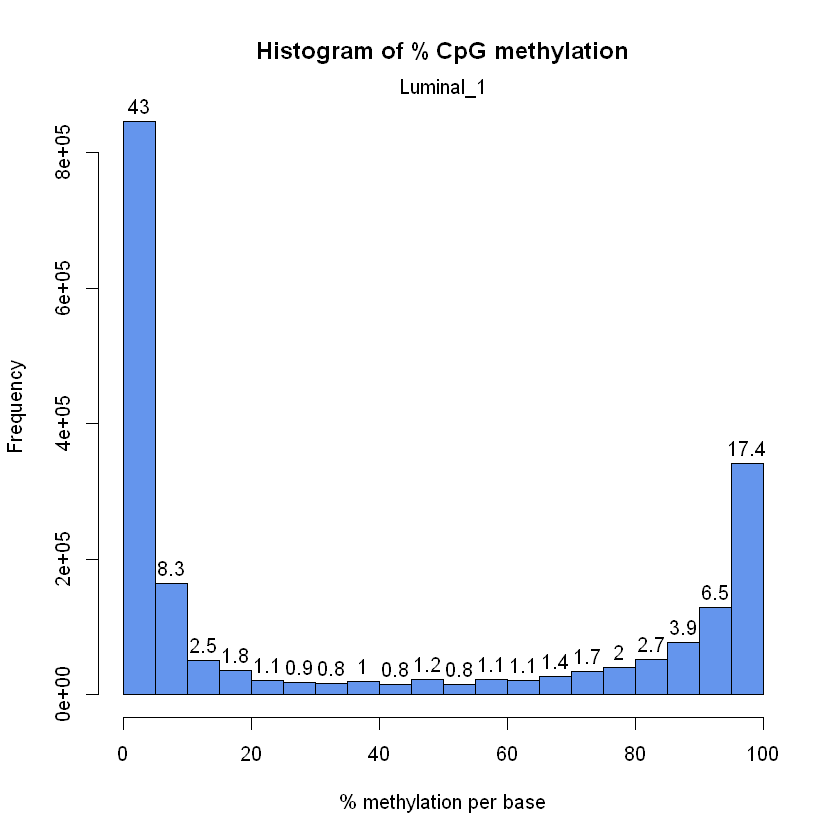

read coverage statistics per base
summary:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0     15.0     22.0     29.4     31.0 423344.0 
percentiles:
    0%    10%    20%    30%    40%    50%    60%    70%    80%    90%    95% 
    10     12     14     17     19     22     25     28     34     45     64 
   99%  99.5%  99.9%   100% 
   132    168    289 423344 



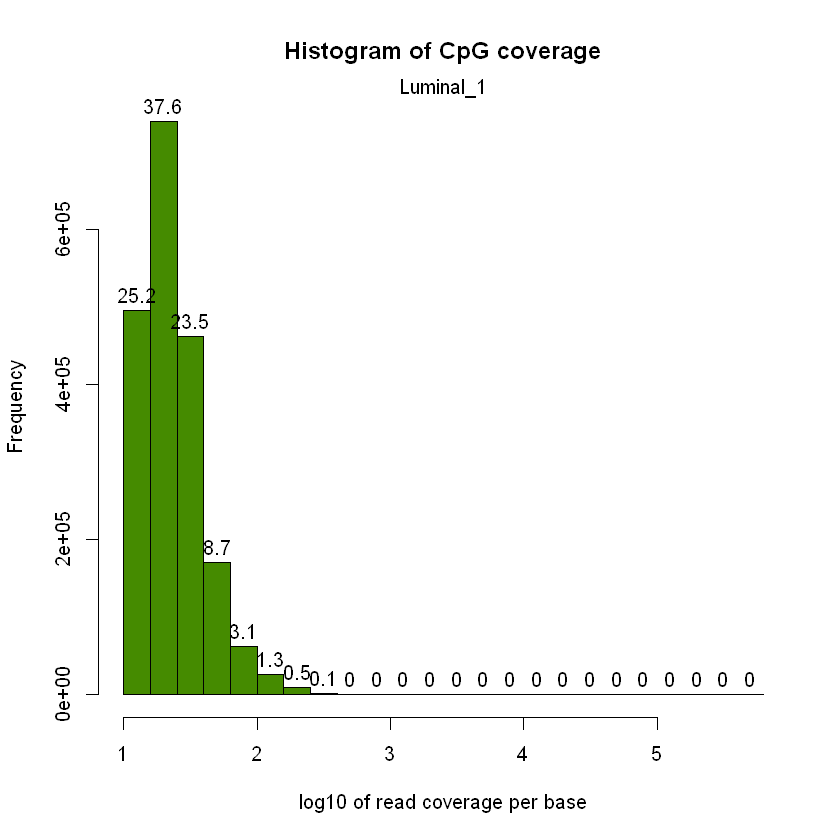

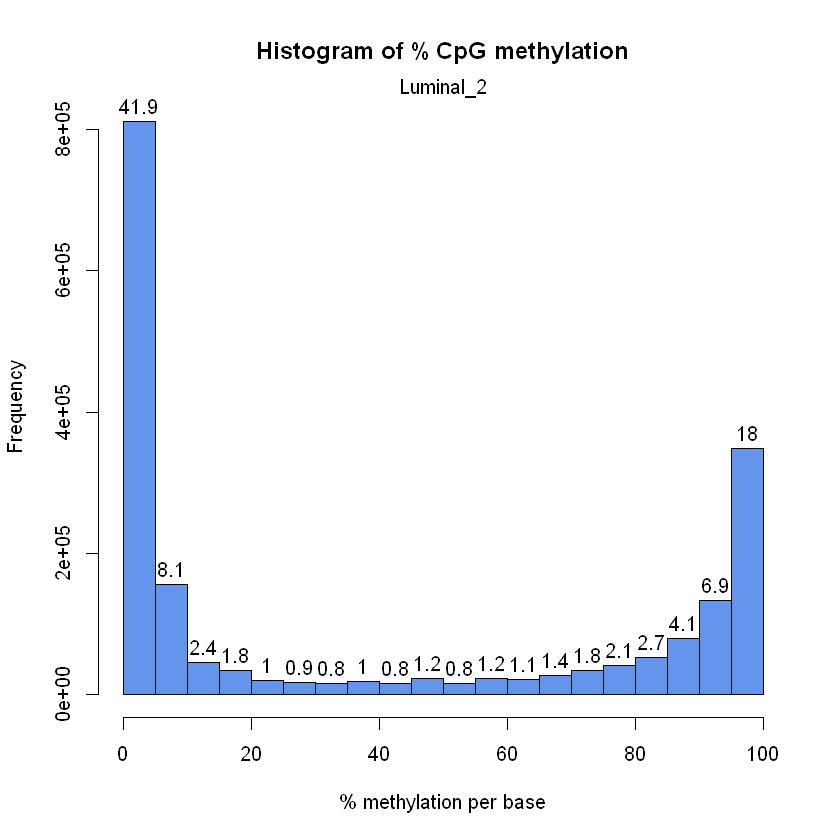

read coverage statistics per base
summary:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0     15.0     21.0     36.3     33.0 890876.0 
percentiles:
        0%        10%        20%        30%        40%        50%        60% 
    10.000     12.000     14.000     16.000     19.000     21.000     25.000 
       70%        80%        90%        95%        99%      99.5%      99.9% 
    29.000     37.000     60.000     98.000    242.000    328.000    586.784 
      100% 
890876.000 



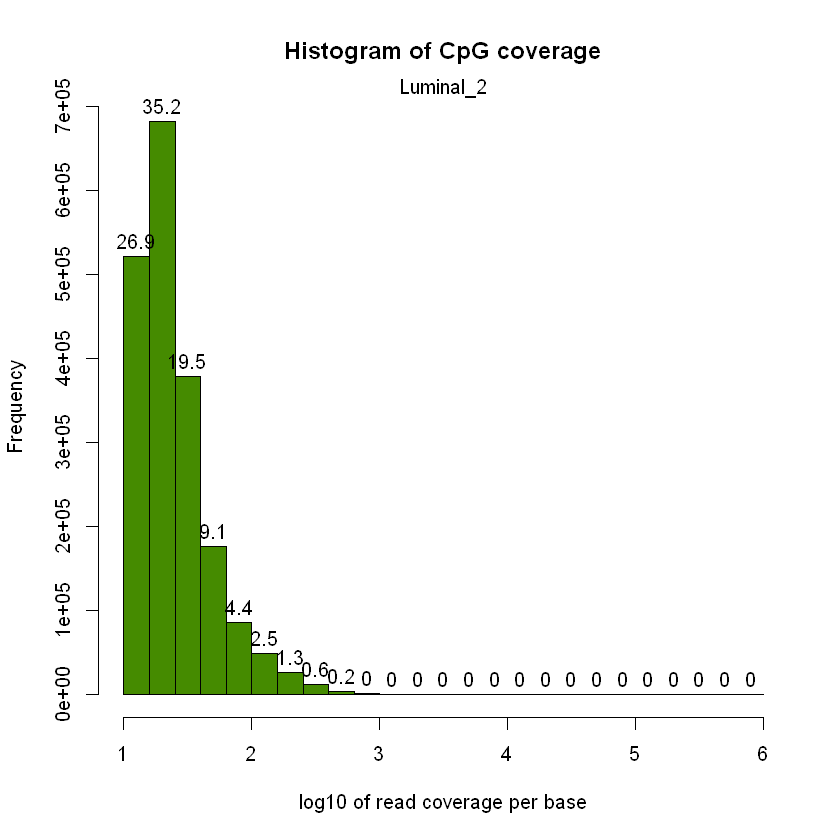

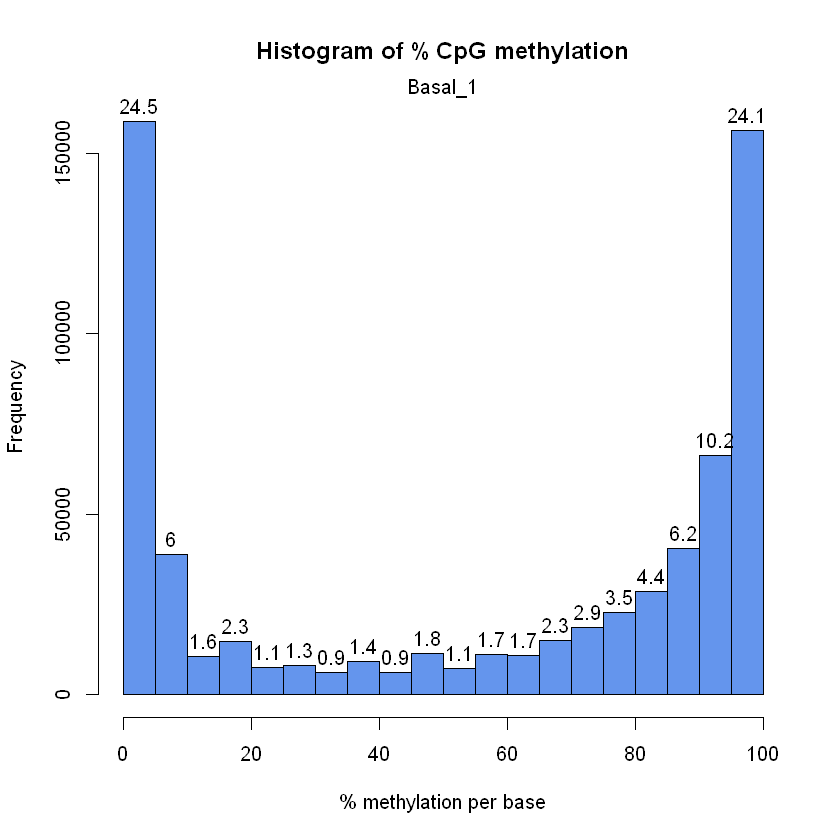

read coverage statistics per base
summary:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0     12.0     17.0     32.9     31.0 460706.0 
percentiles:
    0%    10%    20%    30%    40%    50%    60%    70%    80%    90%    95% 
    10     10     11     13     14     17     20     26     37     61     93 
   99%  99.5%  99.9%   100% 
   193    244    493 460706 



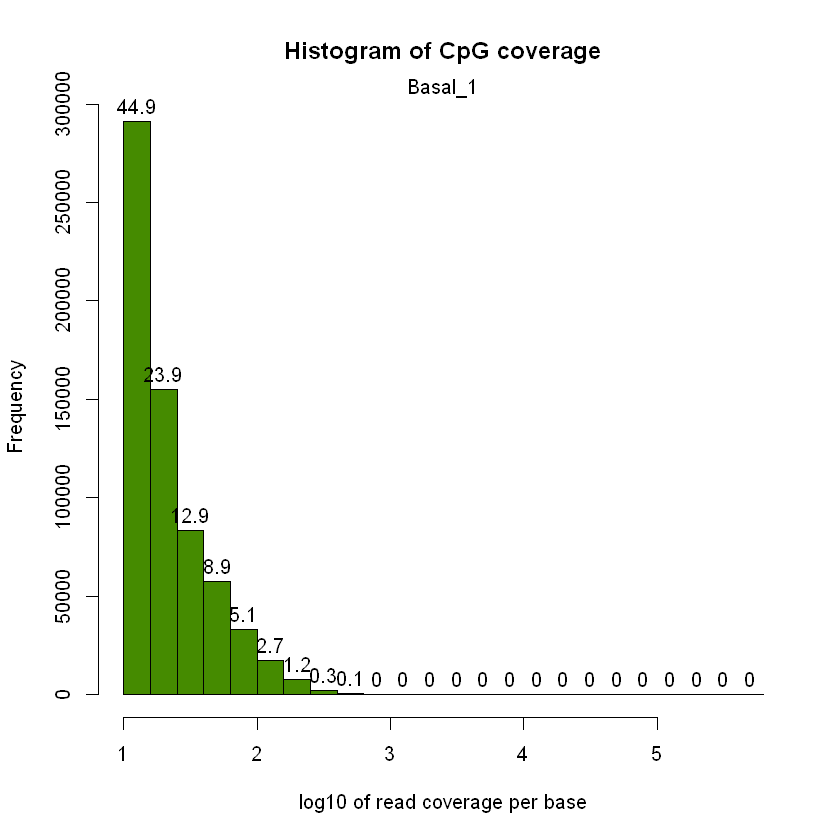

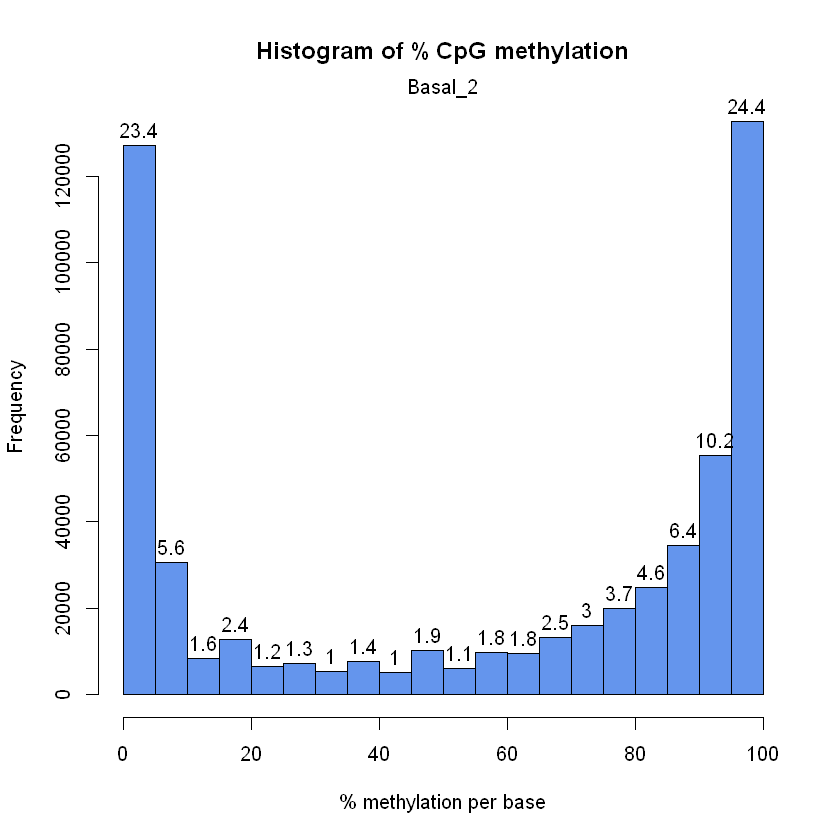

read coverage statistics per base
summary:
    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    10.0     12.0     16.0     30.7     29.0 378861.0 
percentiles:
    0%    10%    20%    30%    40%    50%    60%    70%    80%    90%    95% 
    10     10     11     12     14     16     19     25     34     55     83 
   99%  99.5%  99.9%   100% 
   174    220    517 378861 



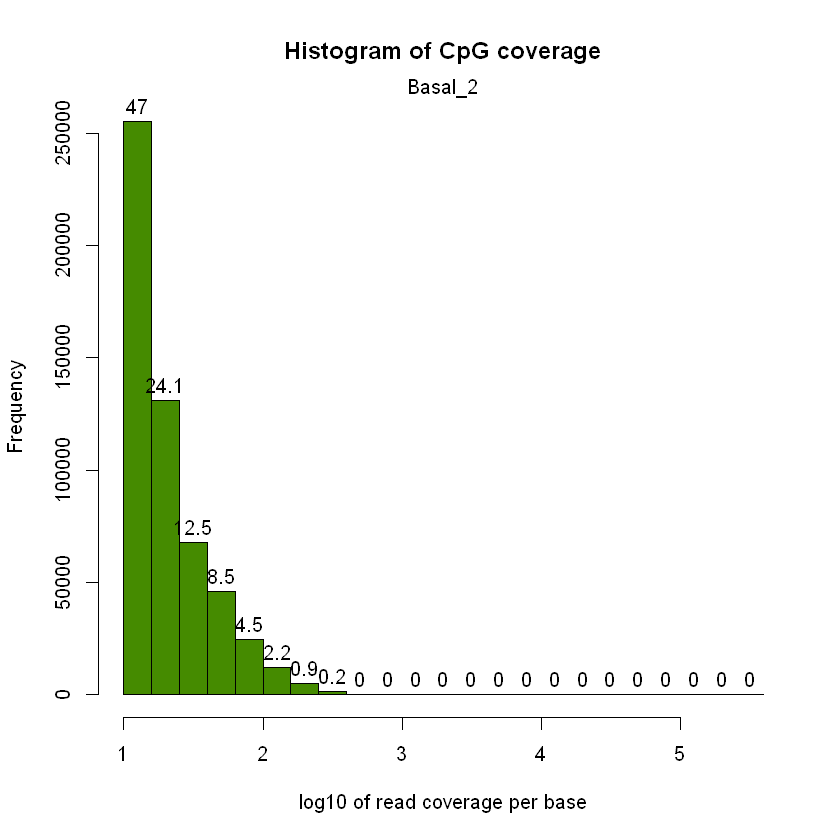

In [7]:
# Get a histogram of the methylation percentage per sample
op <- par(bg = "white")

# Sample 1 (Luminal 1)
getMethylationStats(myobj[[1]], plot=TRUE, both.strands=FALSE)

# Get a histogram of the read coverage per sample
getCoverageStats(myobj[[1]], plot=TRUE, both.strands=FALSE) 
# Get percentile data by setting plot=FALSE 
getCoverageStats(myobj[[1]], plot=FALSE, both.strands=FALSE)

# Sample 2 (Luminal 2)
getMethylationStats(myobj[[2]], plot=TRUE, both.strands=FALSE)

getCoverageStats(myobj[[2]], plot=TRUE, both.strands=FALSE) 
getCoverageStats(myobj[[2]], plot=FALSE, both.strands=FALSE)

# Sample 3 (Basal 1)
getMethylationStats(myobj[[3]], plot=TRUE, both.strands=FALSE)

getCoverageStats(myobj[[3]], plot=TRUE, both.strands=FALSE) 
getCoverageStats(myobj[[3]], plot=FALSE, both.strands=FALSE)

# Sample 4 (Basal 2)
getMethylationStats(myobj[[4]], plot=TRUE, both.strands=FALSE)

getCoverageStats(myobj[[4]], plot=TRUE, both.strands=FALSE) 
getCoverageStats(myobj[[4]], plot=FALSE, both.strands=FALSE)

par(op)


<code style="background:steelblue">                                                                                                              </code>


### Filter Step

It might be useful to filter samples based on coverage. In particular, if samples are suffering from PCR bias or overamplification it could be useful to discard bases with very high read coverage. Furthermore, we would also like to discard bases that have very low read coverage, because these tend to produce unreliable and unstable statistics in the downstream analysis. 

The code below filters a methylRawList and discards bases that have coverage below 10 reads and also discards the bases that have more than 99.9th percentile of coverage in each sample.


<code style="background:salmon">                                                                                                              </code>

* How many bases were filtered?
* The low count filter here is not really necessary, why not? 

---

In [8]:
myobj.filt <- filterByCoverage(myobj,
                      lo.count=10, #low counts are filtered for count(background noise in the equipment)
                      lo.perc=NULL, 
                      hi.count=NULL, 
                      hi.perc=99.9) # high counts are filtered for percentage, highgest 0.1% because it gives too much weight to those
                      # filters that are in this high bereich

# myobj.filt

In [9]:
# Custom function to output filtered numbers
filtered_number <- function(unfiltered, filtered, sample_names) {
    result <- data.frame(
        Sample = sample_names,  
        OriginalBases = sapply(unfiltered, nrow),  # Count rows in each methylRaw object
        FilteredBases = sapply(filtered, nrow),    # Count rows in filtered objects
        BasesFilteredOut = sapply(unfiltered, nrow) - sapply(filtered, nrow),  # Difference
        PercentFilteredOut = (sapply(unfiltered, nrow) - sapply(filtered, nrow)) / sapply(unfiltered, nrow) * 100
    )
    return(result)
}

sample_names <- c("P6_1", "P6_4", "P8_3", "P8_6")

# Function used on myobj
filtered_stats <- filtered_number(myobj, myobj.filt, sample_names)


print(filtered_stats)

  Sample OriginalBases FilteredBases BasesFilteredOut PercentFilteredOut
1   P6_1       1967671       1965682             1989          0.1010840
2   P6_4       1936217       1934280             1937          0.1000404
3   P8_3        648553        647900              653          0.1006857
4   P8_6        543611        543065              546          0.1004395


### Answer Q3: Filter step

**How many bases were filtered?**

- All of the bases were filtered out above the 99.9th percentile (highly repetitive regions or those with PCR-bias). We have a very small percentage of filtered out bases which means the original data was of high quality and we didn't lose much data during filtering.

```r
Sample OriginalBases FilteredBases BasesFilteredOut PercentFilteredOut
1   P6_1       1967671       1965682             1989          0.1010840
2   P6_4       1936217       1934280             1937          0.1000404
3   P8_3        648553        647900              653          0.1006857
4   P8_6        543611        543065              546          0.1004395
```
**The low count filter here is not really necessary, why not?**

- The low count filter was not necessary because we had already set the min parameter (10) when we created the MethylRaw object in the previous step.

<code style="background:steelblue">                                                                                                              </code>

### Normalization

Next, a basic normalization of the coverage values between samples is performed by using a scaling factor derived from differences between the median of the coverage distributions. In the dowstream differential analysis, we will be comparing methylation fractions between samples, so one could think that sequence depth would not matter all that much. After all, 40/80 (mC/C) reads is the same fraction as 400/800 (mC/C) reads. 

However, certain statistical tests (i.e. Fisher’s exact test) will result in different p-values depending on the total number of reads. Thus, if the coverage is quite similar across the samples, this step is not really essential, otherwise it might be a good idea to normalize the data.




---


In [ ]:
myobj.filt.norm <- normalizeCoverage(myobj.filt, method = "median") 

# Sequencing for Sequenziertiefe -> when there is a big difference in the sequencing depth this can lead to false results for gene expression

myobj.filt.norm

In [11]:
# Written by me to check if normalization worked
# Check the median coverage for each sample before and after normalization
calculate_medians <- function(obj) {
  sapply(obj, function(sample) median(sample$coverage))
}

medians_before <- calculate_medians(myobj.filt)
medians_after <- calculate_medians(myobj.filt.norm)

cat("Median coverage before normalization:\n")
print(medians_before)

cat("Median coverage after normalization:\n")
print(medians_after)

# Coverage ranges before normalization
range_before <- sapply(myobj.filt, function(sample) range(sample$coverage))
cat("Coverage range before normalization:\n")
print(range_before)

# Coverage ranges after normalization
range_after <- sapply(myobj.filt.norm, function(sample) range(sample$coverage))
cat("Coverage range after normalization:\n")
print(range_after)

Median coverage before normalization:
[1] 22 21 17 16
Median coverage after normalization:
[1] 22 22 22 22
Coverage range before normalization:
     [,1] [,2] [,3] [,4]
[1,]   10   10   10   10
[2,]  288  586  492  516
Coverage range after normalization:
     [,1] [,2] [,3] [,4]
[1,]   10   10   13   14
[2,]  288  614  637  710


<code style="background:steelblue">                                                                                                              </code>

### Merge Data

In order to do further analysis, we will need to extract the bases that are covered by reads in all our samples. The following function will merge all samples to one object with base-pair locations that are covered in all samples. 

Setting destrand=TRUE (the default is FALSE) will merge reads on both strands of a CpG dinucleotide. This provides better coverage, but only advised when looking at CpG methylation. In addition, setting destrand=TRUE will only work when operating on base-pair resolution, otherwise setting this option TRUE will have no effect. 

**Our data contains no strand info, so the destrand option is not applicable.**

The unite function will return a methylBase object which will be our main object for all comparative analysis. The methylBase object contains methylation information for regions/bases that are covered in all samples.


<code style="background:salmon">                                                                                                              </code>

* How many bases were kept for downstream analysis?

---


### Answer Q4: Downstream analysis

**How many bases were kept for downstream analysis?**

- 424 932 (nrow) bases were kept. 

In [ ]:
meth <- unite(myobj.filt.norm, destrand=FALSE)

# We filter places which are for example always unmethylated
# Filtering this reduces the rate of false positives in my analysis
# BUT issue is also if we filter too much as some normalization models are based on the premise that 70% of data won't change

# We also filter places where there is a known C-T mutation (where we know there is a mutation in this population)
# We filter of this in order to not identify this place as a methylation (although it is really a mutation, there is no C, it is a T in the genome)

meth
nrow(getData(meth))
dim(getData(meth))

<code style="background:steelblue">                                                                                                              </code>

### Further Filtering

High-throughput methylation data contains a lot of CpG sites that have no or little variation among study subjects and are not all that informative for downstream analyses. Nonspecific CpG filtering (i.e., not considering phenotype) is a common dimension reduction procedure performed prior to cluster analysis and differential methylation. For exploratory analysis, it is of general interest to see how samples relate to each other and we might want to remove CpGs that are not variable before doing that. For differential methylation, removing non variable CpGs prior to the analysis will lower the number of tests that needs to be performed, thus reducing multiple correction penalties.

The most commonly used and simple method of standard deviation filtering on methylation ratio values has been shown to be robust and consistent to different real datasets and would suffice for most occasions.

---

We can further remove known C -> T mutations. Mutation locations can be stored in a GRanges object, and we can use that to remove the CpGs overlapping with the mutations. In order to do the overlap operation, we will convert the methylKit object to a GRanges object and do the filtering with the %over% function. The returned object will still be a methylKit object.

---


<code style="background:salmon">                                                                                                              </code>

* How many CpG sites were filtered with each of the above filtering steps?
* Discuss in the group why it would be useful to remove known C -> T mutations?


---


### Answer Q5: Further filtering

**How many CpG sites were filtered with each of the above filtering steps?**

- Initial number of CpG sites: 326531 
- CpG sites filtered by standard deviation: 0 
- CpG sites filtered by mutation overlap: 0 

**Why is it useful to remove known C->T mutations?**

- A C-> T mutation can lead to a false conclusion that this C-Site is unmethylated (because Bisulfite treatment "converted" the C to T) while in reality, this is a mutation and has nothing to do with methylation. Removing them ensures cleaner downstream analyses and avoids wasting computational resources on irrelevant sites.


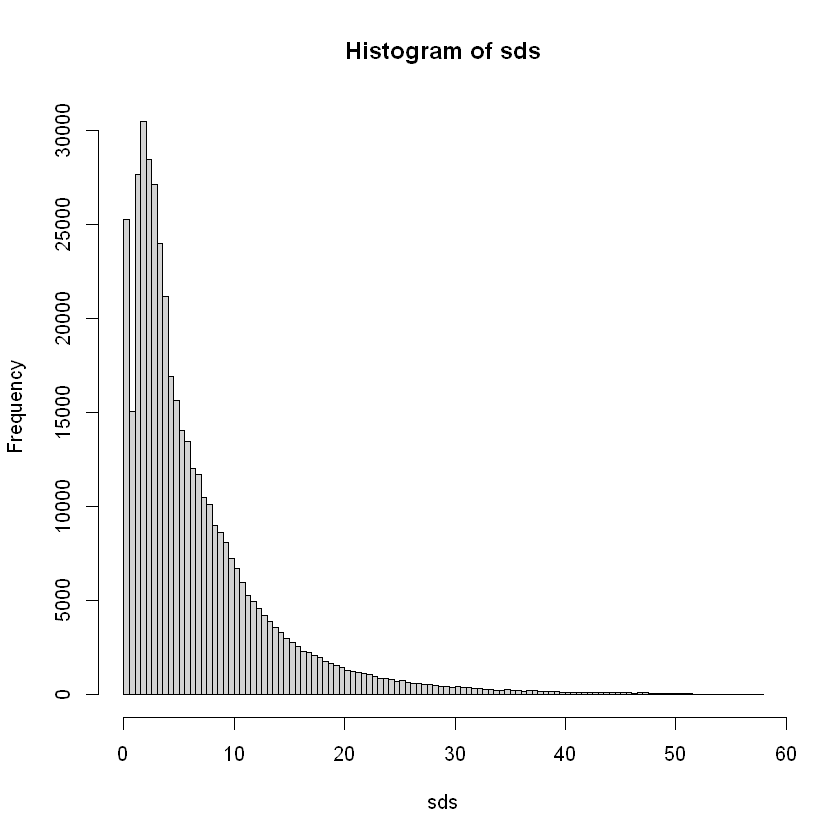

In [13]:
op <- par(bg = "white")
# get percent methylation matrix
pm=percMethylation(meth)

# calculate standard deviation of CpGs
sds=matrixStats::rowSds(pm)

# Visualize the distribution of the per-CpG standard deviation
# to determine a suitable cutoff
hist(sds, breaks = 100)

# keep only CpG with standard deviations (sds) larger than 2%
meth <- meth[sds > 2]

# give the locations of 2 example SNPs
mut <- GRanges(seqnames=c("chr1","chr18"),
         ranges=IRanges(start=c(3020690, 9853326),
                        end=c(3020690,9853326)))

# select CpGs that do not overlap with mutations
meth <- meth[!as(meth,"GRanges") %over% mut, ]


par(op)

In [14]:
# MY CODE: Figuring out the number of filtered CpGs

# Number of CpG sites before any filtering
initial_sites <- nrow(pm)  # The number of rows in the percent methylation matrix
cat("Initial number of CpG sites:", initial_sites, "\n")

# Number of CpG sites after standard deviation filtering
sites_after_sd <- sum(sds > 2)  # The number of CpG sites with standard deviation > 2%
filtered_sd <- initial_sites - sites_after_sd  # CpG sites filtered out due to SD filtering
cat("CpG sites filtered by standard deviation:", filtered_sd, "\n")

# Number of CpG sites after removing overlaps with mutations
sites_after_mut <- nrow(meth)  # Remaining CpG sites after mutation filtering
filtered_mut <- sites_after_sd - sites_after_mut  # CpG sites filtered out due to mutations
cat("CpG sites filtered by mutation overlap:", filtered_mut, "\n")

# Check if any standard deviations are less than 2
any_below_2 <- any(sds <= 2)
cat("Are there any CpG sites with SD <= 2? ", any_below_2, "\n")

Initial number of CpG sites: 424932 
CpG sites filtered by standard deviation: 98400 
CpG sites filtered by mutation overlap: 1 
Are there any CpG sites with SD <= 2?  TRUE 


<code style="background:steelblue">                                                                                                              </code>


### Data Structure/Outlier Detection

We can check the **correlation** between samples using getCorrelation. This function will either plot scatter plot and Pearson correlation coefficients or just print a correlation matrix if plot=FALSE. 

Also **hierarchical clustering** of distance measures derived from each samples’ percentage methylation can be used to visualize how similar the samples are. Check the function ```clusterSamples``` to see which distance measures and clustering methods are available.

Another very useful visualization is a **principal component analysis** plot. Here multidimensional data (i.e. we have as many dimensions in this data as there are CpG loci in meth) are projected into 2 or 3-dimensional space while at the same time maintaining as much variation in the data as possible. Samples that are more alike will be clustered together in PC space, so by looking at this plot we can see what is the largest source of variation in data and whether there are sample swaps and/or outlier samples.```PCASamples``` is a function in methylKit that will perform PCA and plot the first two principal components.

---

<code style="background:salmon">                                                                                                              </code>

* Do the plots look as expected?
* What does the PCA plot of our dataset tell you? 
* What is the biggest source of variation on the data? 
* Does it look samples are swapped? 
* Do there seem to be outliers among the samples?


---


### Answer Q5: Data structure and outlier detection
```r
          Luminal_1 Luminal_2   Basal_1   Basal_2
Luminal_1 1.0000000 0.9733819 0.8861950 0.8831778
Luminal_2 0.9733819 1.0000000 0.8870822 0.8841958
Basal_1   0.8861950 0.8870822 1.0000000 0.9420206
Basal_2   0.8831778 0.8841958 0.9420206 1.0000000
```
#### **Do the plots look as expected?**

<p align="left">
  <img src="Cpg_cor_hist.png" alt="Cpg Cor" width="300">
  <img src="cluster_graph.png" alt="Cluster" width="300">
</p>

- The Pearson coefficients in the correlation matrix make sense-> The luminal samples (Luminal_1 and Luminal_2) show a very strong correlation (r = 0.97). Basal samples (Basal_1 and Basal_2) also correlate strongly (0.94). This confirms that the samples are part of same subtype. The correlation between luminal and basal samples is lower (r = 0.88 or 0.89) which means the two different subtypes have different methylation patterns. 

- The CpG methylation clustering plot and the PCA plot look somewhat surprising as they just clusters the 4 samples with each other (we expected individual CpGs to be clustered). 

#### **What does the PCA plot of our dataset tell you?**

<p align="left">
  <img src="PCA_graph.png" alt="PCA" width="300">
</p>

- Luminal samples (Luminal_1 and Luminal_2) are clustering very tightly together near the origin of the plot meaning that they are very strongly correlated (confirming our observations from the correlation matrix). 

- Basal samples (Basal_1 and Basal_2) are far apart from the Luminal samples in the PC1 dimension meaning that there are strong methylation differences between the subtypes. Basal samples are less separated from each other on the PC2 dimension meaning that there is some variability within the basal subtype.


#### **What is the biggest source of variation on the data?**

- PC1 explains the largest part of the variation meaning that subtype difference in methylation between Luminal and Basal samples is the biggest source of variation. PC2 is the source of variation between the two basal samples.

#### **Does it look samples are swapped?** 

- The dendrogram in the clustering plot correctly groups Luminal samples together and Basal samples together which means that the samples were not swapped.

#### **Do there seem to be outliers among the samples?**

- No obvious outliers are visible in the plots. No samples significantly deviate from the subtype cluster.

          Luminal_1 Luminal_2   Basal_1   Basal_2
Luminal_1 1.0000000 0.9733819 0.8861950 0.8831778
Luminal_2 0.9733819 1.0000000 0.8870822 0.8841958
Basal_1   0.8861950 0.8870822 1.0000000 0.9420206
Basal_2   0.8831778 0.8841958 0.9420206 1.0000000


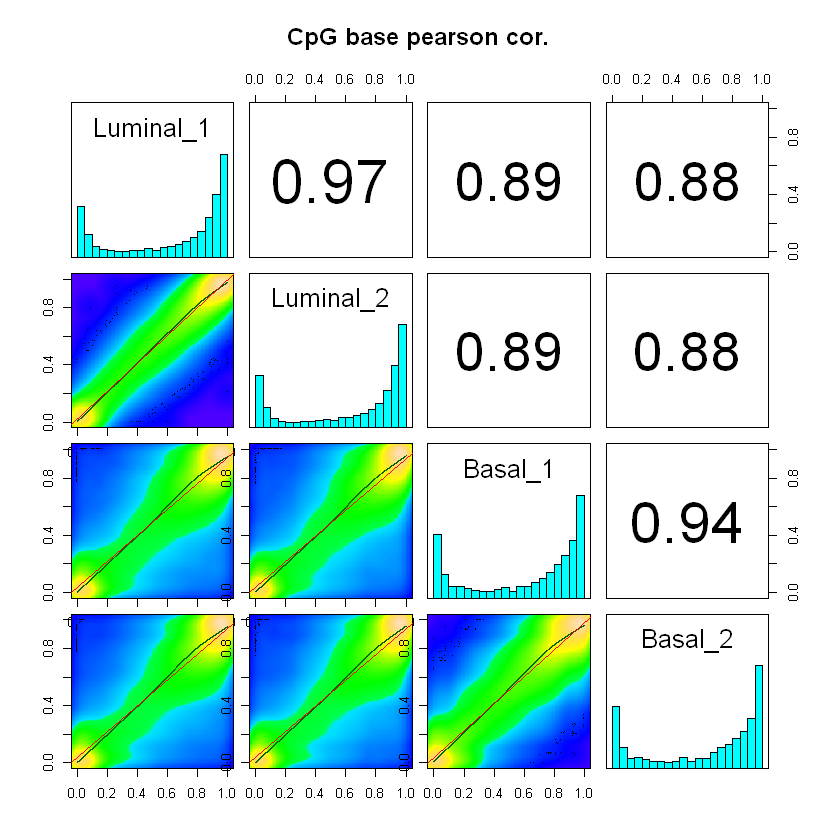

In [15]:
# Correlation between samples
op <- par(bg = "white")
suppressWarnings(getCorrelation(meth,plot=TRUE))
par(op)


Call:
hclust(d = d, method = HCLUST.METHODS[hclust.method])

Cluster method   : ward.D2 
Distance         : pearson 
Number of objects: 4 


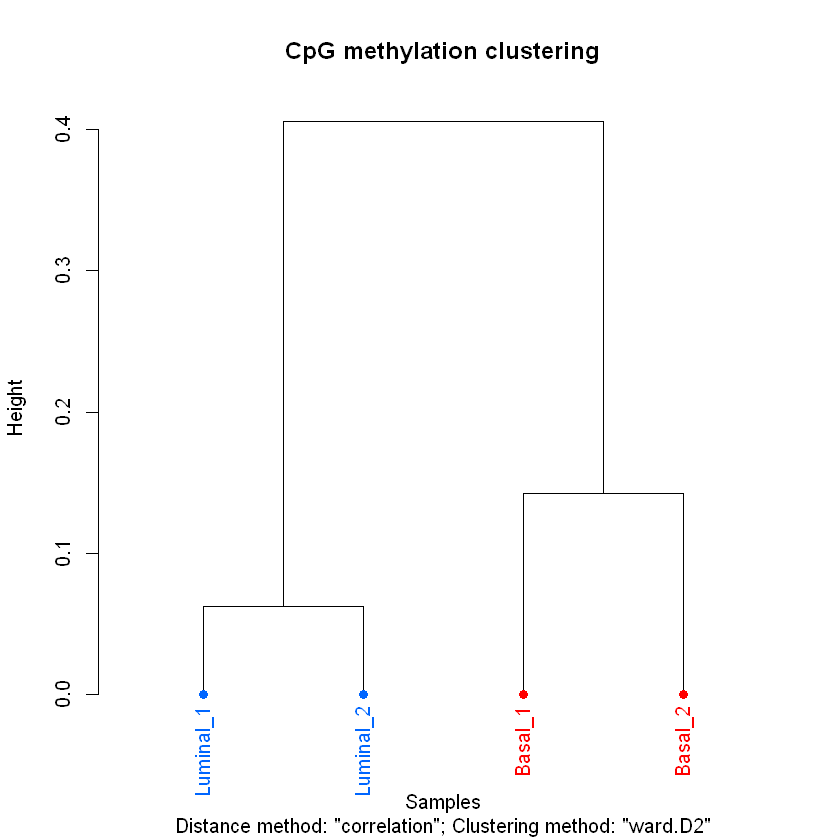

In [16]:
# Cluster samples
op <- par(bg = "white")
clusterSamples(meth, dist="correlation", method="ward.D2", plot=TRUE)
par(op)

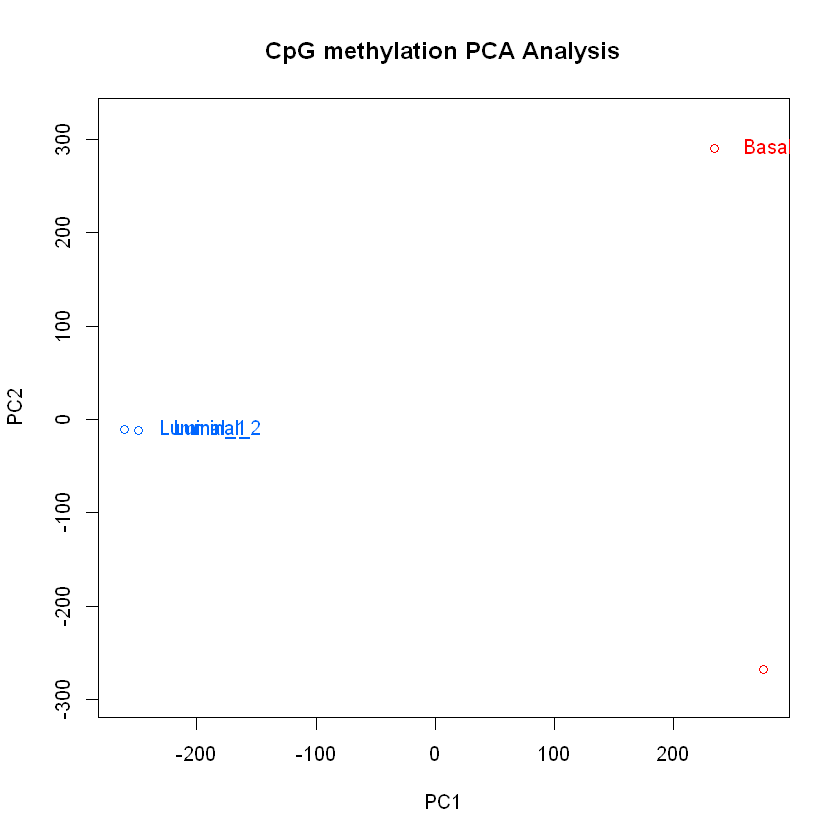

In [17]:
op <- par(bg = "white")
PCASamples(meth)
par(op)

<code style="background:steelblue">                                                                                                              </code>


## Differential Methylation

### Single CpG Sites

If the basic statistics of the samples look OK and the data structure seems reasonable, we can proceed to the differential methylation step. Differential DNA methylation is usually calculated by comparing the proportion of methylated Cs in a test sample relative to a control. 

* In simple comparisons between such pairs of samples (i.e. test and control), methods such as Fisher’s Exact Test can be applied when there are no replicates for test and control cases. 
* If replicates are available, regression based methods are generally used to model methylation levels in relation to the sample groups and variation between replicates. In addition, an advantage of regression methods over Fisher’s exact test is that it allows for the inclusion of sample specific covariates (continuous or categorical) and the ability to adjust for confounding variables.

The ```calculateDiffMeth``` function is the main function to calculate differential methylation in the methylKit package. Depending on the sample size per each set it will either use Fisher’s exact or logistic regression to calculate P-values. In practice, the number of samples per group will determine which of the two methods will be used (logistic regression or Fisher’s exact test). If there are multiple samples per group, methylKit will employ the logistic regression test. Otherwise, when there is one sample per group, Fisher’s exact test will be used. P-values will automatically be corrected for multiple testing using the Benjamini-Hochberg FDR method.


* Alternatively, the function ```calculateDiffMethDSS``` provides an interface to the beta-binomial model from the DSS package. This might sometimes be more statistically sound as it can account for both sampling and epigenetic variability
* If you want to compare multiple treatment groups, you can do as above using a treatment vector as c(2,2,1,1,0,0) to detect CpGs differing in any of the groups. For specific pairwise comparisons you have to use the reorganize function and rerun ```calculateDiffMeth```


The data can be visualized in a Volcano Plot.


---

<code style="background:salmon">                                                                                                              </code>

* Create a Volcano Plot which indicates significantlly differentially methylated data (adj. p-value <0.01, difference > abs(+/-25))


---



In [18]:
# Test for differential methylation... This will take some minutes.
myDiff <- calculateDiffMeth(meth,
                            overdispersion = "MN", # MN and BH are different methods for multiple test
                            adjust="BH")

two groups detected:
 will calculate methylation difference as the difference of
treatment (group: 1) - control (group: 0)



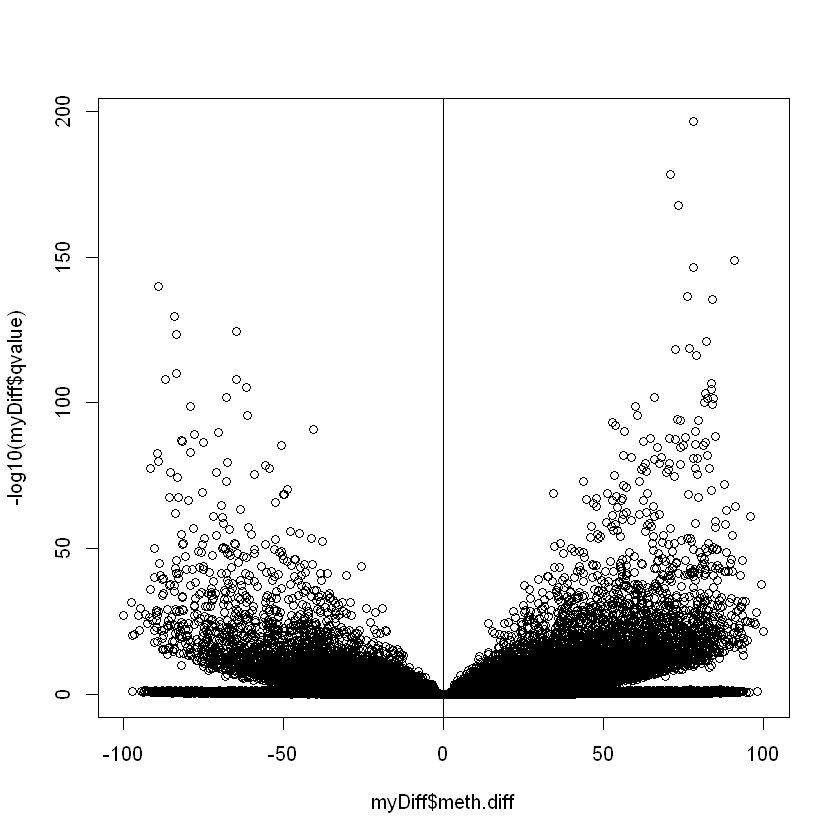

In [ ]:

op <- par(bg = "white")

# Simple volcano plot to get an overview of differential methylation
plot(myDiff$meth.diff, -log10(myDiff$qvalue))
abline(v=0)

par(op)


In [110]:
head(meth)

,chr,start,end,strand,coverage1,numCs1,numTs1,coverage2,numCs2,numTs2,coverage3,numCs3,numTs3,coverage4,numCs4,numTs4
,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,chr1,3020725,3020725,*,37,37,0,49,47,2,19,19,0,30,29,1
3,chr1,3045300,3045300,*,59,16,43,42,19,23,26,12,14,23,14,9
4,chr1,3045307,3045307,*,59,50,9,42,27,15,26,22,4,23,19,4
5,chr1,3059415,3059415,*,67,55,12,103,75,28,58,48,10,66,50,16
7,chr1,3059436,3059436,*,67,45,22,103,62,41,58,39,19,66,38,28
8,chr1,3059574,3059574,*,65,59,6,101,93,8,52,43,9,65,59,6


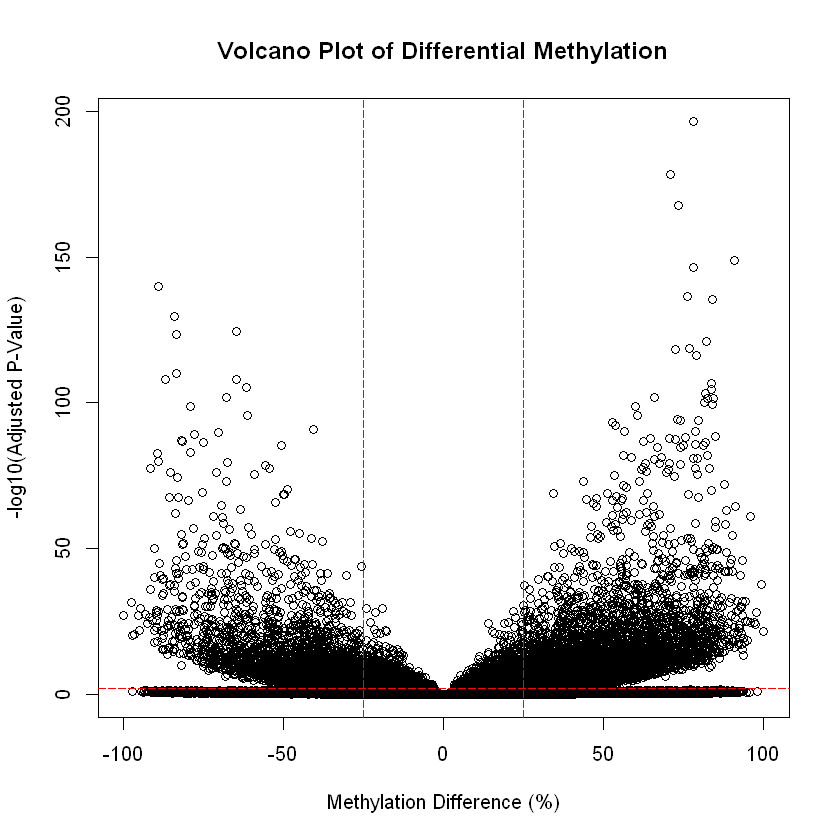

In [107]:
op <- par(bg = "white")

# Volcano plot
plot(myDiff$meth.diff, -log10(myDiff$qvalue),
     xlab = "Methylation Difference (%)", 
     ylab = "-log10(Adjusted P-Value)",
     main = "Volcano Plot of Differential Methylation")

# lines showing +/- 25% difference and p-value <0.01 significance (h= 2 which is -10 log(0.01))
abline(v = c(-25, 25), col = "red", lty = 5)  # vertical lines for ±25% difference
abline(h = 2, col = "red", lty = 5)  # horizontal line for adj. p-value <0.01

par(op)


### Answer Q6: Volcano plot

#### **Create a Volcano Plot which indicates significantlly differentially methylated data (adj. p-value <0.01, difference > abs(+/-25))**

<img src="volcano_plot.png" alt="Volcano Plot" width="350">

##### Interpretation

- The x-axis on the volcano plot represents the % difference in methylation between our basal (test) and luminal (control) samples. Positive values on the x-axis mean more CpG sites were methylated in basal compared to luminal while negative values mean CpG sites were less methylated in basal compared to luminal.

- The y-axis plots the statistical significance of the methylation difference (the p-value). Because the p-value is transformed with -lo10(p-value), lower p-values (higher significance) appear higher on the y-axis while higher p-values (lower significance) appear closer to 0 on the y-axis.

- Points that are clustered around 0 +/- 25% (between the red lines on x-axis) and under the p-value limit of 0.01 (under the red line on y-axis) are not biologically and statistically significant. +/-25% is not enough of a difference in methylation to signify any biological relevance and a p-value above 0.01 shows low statistical significance (although we could adjust this threshold depending on the analysis).

- Those points that are on the far left or far right (on the x-axis) show a high difference in methylation. The higher these points are on the y-axis, the more statistically significant is the methylation difference between the 2 samples. 

<code style="background:steelblue">                                                                                                              </code>


Next, visualize the number of hyper- and hypomethylation events per chromosome, as a percent of the sites with minimum coverage and minimal differential methylation. By default this is a 25% change in methylation and all samples with 10X coverage.

---

Warning message in eval(quote(list(...)), env):
"NAs introduced by coercion"


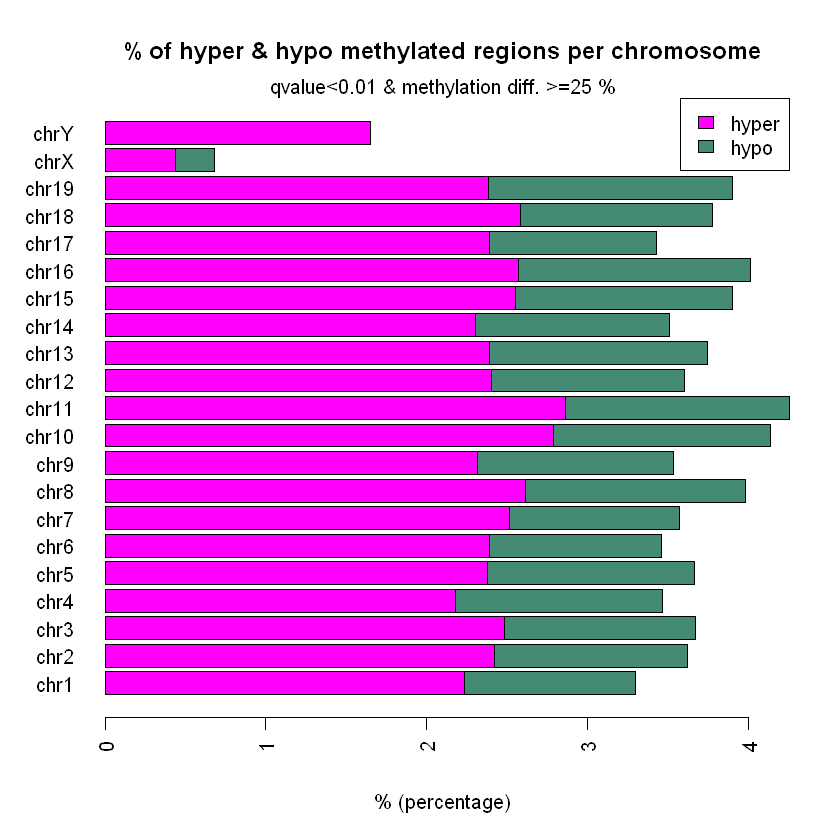

In [77]:
# Overview of percentage hyper and hypo CpGs per chromosome.
op <- par(bg = "white")

diffMethPerChr(myDiff)

par(op)

<code style="background:steelblue">                                                                                                              </code>

After q-value calculation, we can select the differentially methylated regions/bases based on q-value and percent methylation difference cutoffs of Treatment versus control. Following bits of code selects the bases that have q-value < 0.01 and percent methylation difference larger than 25%. If you specify type="hyper" or type="hypo" options, you will extract the hyper-methylated or hypo-methylated regions/bases.


---

In [ ]:
# get hyper methylated bases and order by qvalue # qvalue is p value, 25 is 25%
myDiff25p.hyper <- getMethylDiff(myDiff,
                              difference=25,
                              qvalue=0.01,
                              type="hyper")
myDiff25p.hyper <- myDiff25p.hyper[order(myDiff25p.hyper$qvalue),]

# get hypo methylated bases and order by qvalue
myDiff25p.hypo <- getMethylDiff(myDiff,
                             difference=25,
                             qvalue=0.01,
                             type="hypo")
myDiff25p.hypo <- myDiff25p.hypo[order(myDiff25p.hypo$qvalue),]

# get all differentially methylated bases and order by qvalue
myDiff25p <- getMethylDiff(myDiff,
                        difference=25,
                        qvalue=0.01)
myDiff25p <- myDiff25p[order(myDiff25p$qvalue),]

# myDiff25p

<code style="background:steelblue">                                                                                                              </code>


### CpG Annotation

To help with the biological interpretation of the data, we will annotate the differentially methylated regions/bases using the genomation package. The most common annotation task is to see where CpGs of interest land in relation to genes and gene parts and regulatory regions: Do they mostly occupy promoter, intronic or exonic regions? Do they overlap with repeats? Do they overlap with other epigenomic markers or long-range regulatory regions? In this example, we read the gene annotation information from a BED file (Browser Extensible Data - file format containing genome coordinates and associated annotations) and annotate our differentially methylated regions with that information using genomation functions.

The annotation files that are provided are:

* Gene information: mm10_Refseq_genes.bed
* CpG island information: mm10_cpg.bed

The function creates an AnnotationByGeneParts object, containing - for each target CpG - data such as the nearest transcription start site and the genomic structure it is located on. Several accessor functions from the genomation package allow for interaction with such an object.


---



In [80]:
# First load the annotation data; i.e the coordinates of promoters, TSS, intron and exons
refseq_anot <- readTranscriptFeatures("data/mm10_Refseq_genes.bed")

# Annotate hypermethylated CpGs ("target") with promoter/exon/intron
# information ("feature"). This function operates on GRanges objects, so we # first coerce the methylKit object to GRanges.
myDiff25p.hyper.anot <- annotateWithGeneParts(target = as(myDiff25p.hyper,"GRanges"),
                                              feature = refseq_anot)

# Summary of target set annotation
myDiff25p.hyper.anot

Reading the table...

Calculating intron coordinates...

Calculating exon coordinates...

Calculating TSS coordinates...

Calculating promoter coordinates...

Outputting the final GRangesList...


Summary of target set annotation with genic parts

Rows in target set: 7766

-----------------------

percentage of target features overlapping with annotation:



percentage of target features overlapping with annotation:

(with promoter > exon > intron precedence):



percentage of annotation boundaries with feature overlap:



summary of distances to the nearest TSS:





  promoter       exon     intron intergenic 
     10.91      19.06      52.77      31.46 
  promoter       exon     intron intergenic 
     10.91      14.51      43.12      31.46 
promoter     exon   intron 
    1.24     0.35     1.35 
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0    3642   11489   24772   28552  883745 

In [81]:
# View the distance to the nearest Transcription Start Site; the target.row column in the output indicates the row number in the initial target set
dist_tss <- getAssociationWithTSS(myDiff25p.hyper.anot)
head(dist_tss)

# See whether the differentially methylated CpGs are within promoters,introns or exons; the order is the same as the target set
getMembers(myDiff25p.hyper.anot)

,target.row,dist.to.feature,feature.name,feature.strand
,<int>,<dbl>,<chr>,<fct>
2129,1,10081,NM_027211.2,-
4842,2,-49526,XR_376017.4,+
1578,3,50089,XR_380751.2,-
4210,4,-13832,XM_006523957.4,-
2635,5,-3489,NM_011117.2,-
44051,6,19724,XM_030253566.1,+


prom,exon,intron
0,0,1
0,0,1
0,0,1
0,0,1
0,0,1
0,0,0
0,0,1
0,0,1
0,0,0
0,1,0


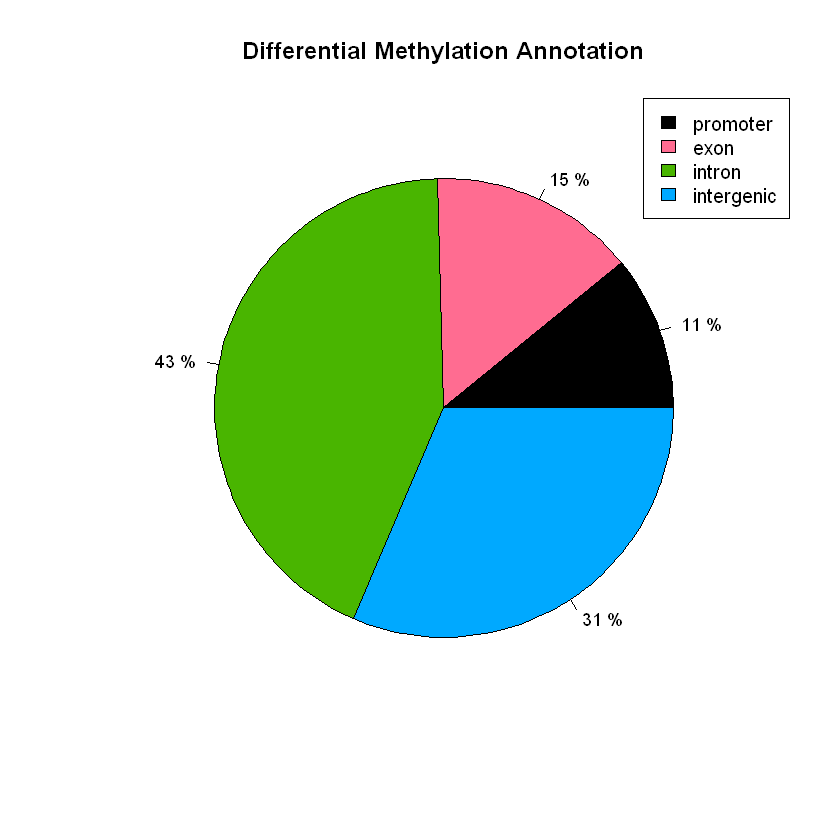

In [83]:
# This can also be summarized for all differentially methylated CpGs
op <- par(bg = "white")
plotTargetAnnotation(myDiff25p.hyper.anot, main = "Differential Methylation Annotation")
par(op)

<code style="background:steelblue">                                                                                                              </code>


Similarly, it is possible to annotate the differentially methylated CpGs with CpG Island membership using readFeatureFlank and annotateWithFeatureflank. Using these functions you read from a BED file with feature info (here the location of the CpG Islands) and with the flank parameter you can define a region around these features (here the “shores” are defined as 2000 bases around the Islands).

---

CpGi,shores
0,0
0,0
0,0
0,0
0,1
0,1


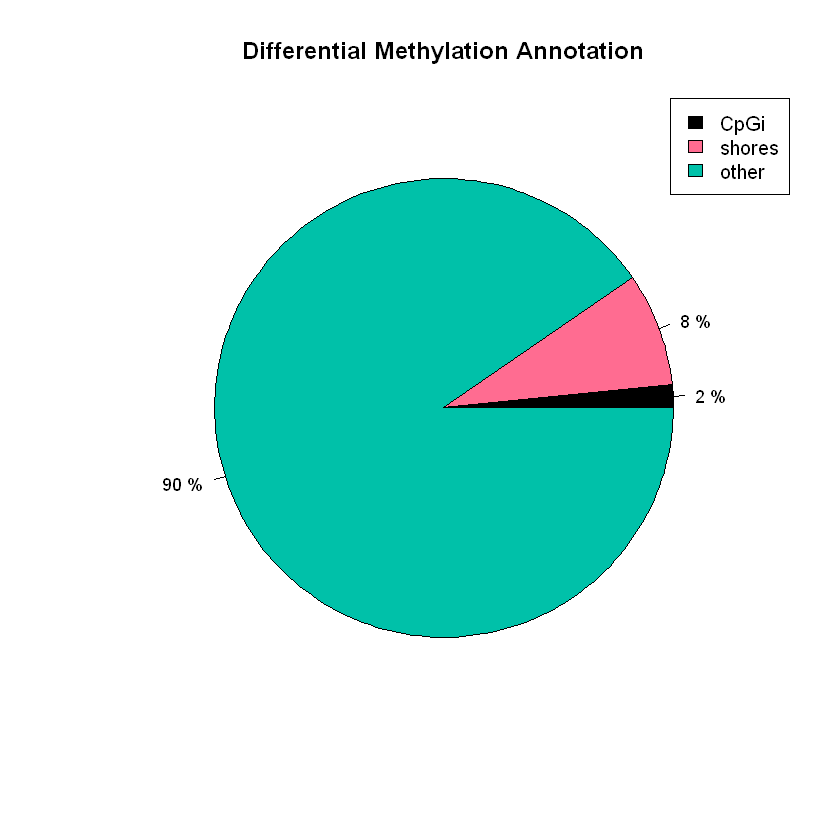

In [85]:
# Load the CpG info
cpg_anot <- readFeatureFlank("data/mm10_cpg.bed", feature.flank.name = c("CpGi", "shores"), flank=2000)
diffCpGann <- annotateWithFeatureFlank(as(myDiff25p,"GRanges"), feature = cpg_anot$CpGi, flank = cpg_anot$shores, feature.name = "CpGi", flank.name = "shores")

# See whether the CpG in myDiff25p belong to a CpG Island or Shore
head(getMembers(diffCpGann))
op <- par(bg = "white")
# This can also be summarized for all differentially methylated CpGs
plotTargetAnnotation(diffCpGann, main = "Differential Methylation Annotation")
par(op)

<code style="background:lightblue">                                                                                                              </code>

### OPTIONAL

### Differentially Methylated Regions

Since we are often more interested in the different methylation of multiple CpGs across samples instead of a single site, we can also summarize methylation information over a set of defined functional regions such as promoters or CpG islands. The function below summarizes the methylation information over a given set of CpG Islands and outputs a methylRaw or methylRawList object depending on the input. We are using the output of genomation functions used above to provide the locations of the Islands. For these regional summary functions, we need to provide regions of interest as GRanges object.

---


In [ ]:
# You can ignore the warnings here...
suppressWarnings({
    # Summarize the original object counts over a certain region, here the CpG Islands
    myobj_islands <- regionCounts(myobj, cpg_anot$CpGi)
    # Filter the summarized counts by coverage
    myobj_islands_filt <- filterByCoverage(myobj_islands,
                          lo.count=10,
                          lo.perc=NULL,
                          hi.count=NULL,
                          hi.perc=99.9)
    # Perform simple normalization
    myobj_islands_filt_norm <- normalizeCoverage(myobj_islands_filt, method = "median")
    # Merge the samples again
    meth_islands <- unite(myobj_islands_filt_norm, destrand=FALSE)

})

In [ ]:
# You can ignore the warnings here...
suppressWarnings({
    # Test for differential methylation... This might take a few minutes.
    myDiff_islands <- calculateDiffMeth(meth_islands)
    # Rank by significance
    myDiff_islands <- myDiff_islands[order(myDiff_islands$qvalue),]
    # get all differentially methylated CpG Islands
    myDiff_islands_25p <- getMethylDiff(myDiff_islands,difference=25,qvalue=0.01)
    })

In [ ]:
myDiff_islands_25p_ann <- annotateWithGeneParts(as((myDiff_islands_25p), "GRanges"), refseq_anot)
# View the distance to the nearest Transcription Start Site; the target.row column indicates the row number in myDiff_islands_25p
head(getAssociationWithTSS(myDiff_islands_25p_ann))

<code style="background:lightblue">                                                                                                              </code>

### OPTIONAL
### De-novo: Sliding Window

Besides grouping by functional regions, you can also group CpGs in a sliding window along the genome for a more unbiased approach. As for the functional regions, we would start again from the original object but this time group the CpGs in a certain predefined window. After this, the usual filterByCoverage, normalizeCoverage and unite functions are used before doing calculatedDiffMeth.

---

In [ ]:
# Reconstruct original object, keeping a lower coverage this time
myobj_lowCov <- methRead(file.list,
           sample.id=list("Luminal_1","Luminal_2","Basal_1","Basal_2"),
           pipeline = "bismarkCoverage",
           assembly="mm10",
           treatment=c(1,1,0,0),
           mincov = 3
           )

# Group the counts
tiles <- tileMethylCounts(myobj_lowCov,win.size=1000,step.size=1000,cov.bases = 10)

# Inspect data
head(tiles[[1]])

<code style="background:lightblue">                                                                                                              </code>


### OPTIONAL
### Visualization

The results of a differential analysis can be exported as a bedGraph; a format that allows display of continuous-valued data in track format. This display type is useful for probability scores, percentages and transcriptome data. By uploading this BED file to a genome browser such as the UCSC Genome Browser, you can create custom visualizations of the genome architecture surrounding CpGs or regions of interest. The bedgraph function produces a UCSC compatible file; by specifying the col.name the exact information to be plotted can be collected. For a methylDiff object this can be one of “pvalue”, “qvalue” or “meth.diff”.


---


In [ ]:
bedgraph(myDiff25p, col.name = "meth.diff", file.name = "diff_cpg_25p.bed")